# How does energy consumption vary across the city of Chicago?
## Stephen Steiner

In this project, I will look at how energy consumption varies with the seasons, location in the city, age of the building, and price. I plan to perform basic regression analyses to determine these relationships and also plan to look at the elasticities of price and temperature.

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas 
from shapely.geometry import Point
from pandas_datareader import data, wb
import patsy                           
import statsmodels.api as sm        
import statsmodels.formula.api as smf
import linearmodels.iv as iv   
from linearmodels import PanelOLS as pan

In [2]:
# Import and clean data on Chicago energy consumption.

energy = pd.read_csv('Energy_Usage_2010.csv', low_memory=False, thousands=',')

energy.columns = map(str.lower, energy.columns)
energy.rename(columns={'community area name':'community', 'total population':'pop', 
                       'term april 2010':'therm_apr', 'therm january 2010':'therm_jan', 
                       'therm february 2010':'therm_feb', 'therm march 2010':'therm_mar', 
                       'therm may 2010':'therm_may', 'therm june 2010':'therm_jun', 
                       'therm july 2010':'therm_jul', 'therm august 2010':'therm_aug', 
                       'therm september 2010':'therm_sep', 'therm october 2010':'therm_oct',
                       'therm november 2010':'therm_nov', 'therm december 2010':'therm_dec',
                       'kwh april 2010':'kwh_apr', 'kwh january 2010':'kwh_jan', 
                       'kwh february 2010':'kwh_feb', 'kwh march 2010':'kwh_mar', 
                       'kwh may 2010':'kwh_may', 'kwh june 2010':'kwh_jun', 
                       'kwh july 2010':'kwh_jul', 'kwh august 2010':'kwh_aug', 
                       'kwh september 2010':'kwh_sep', 'kwh october 2010':'kwh_oct',
                       'kwh november 2010':'kwh_nov', 'kwh december 2010':'kwh_dec',
                       'total kwh':'total_kwh', 'total therms':'total_therms',
                       'average stories':'avg_stories', 'average building age':'avg_build_age', 
                       'building type':'build_type', 'average housesize':'avg_housesize',
                       'occupied units':'occ_units', 'occupied units percentage':'occ_units_pct', 
                       'occupied housing units':'occ_house', 'kwh total sqft':'kwh_sqft',
                       'therms total sqft': 'therm_sqft', 'therms sqft mean 2010':'therm_sqftmean', 
                       'kwh sqft mean 2010':'kwh_sqftmean', 'kwh sqft standard deviation 2010':'kwh_sqftstd',
                       'therms sqft standard deviation 2010':'therm_sqftstd'}, inplace=True)

energy['tot_kwh_percap'] = energy['total_kwh']/energy['pop']
energy['tot_therm_percap'] = energy['total_therms']/energy['pop']

energy['tot_kwh_percap'] = energy['tot_kwh_percap'].replace(np.inf, np.nan)
energy['tot_therm_percap'] = energy['tot_therm_percap'].replace(np.inf, np.nan)

## Here is where I start making the maps that will show the kwh and therms consumed in the months of August and December.

In [3]:
# Read in the map for the Chicago communities

chicago_map = geopandas.read_file('Boundaries - Community Areas (current)/geo_export_afe8915c-ab07-4bae-af48-b8f605c7f92f.shp')
chicago_map['community'] = [com.title() for com in chicago_map['community']]

In [4]:
# Change the census block data in 'energy' from float to string
# Merge energy with the map of Chicago

energy2 = energy.copy()

energy2['census block'] = energy2['census block'].astype(str)
energy2['census block'] = [chic[:-2] for chic in energy2['census block']]

energy_chicago = pd.merge(left=chicago_map, right=energy2, on='community', how='outer')

energy_comms = energy_chicago[(energy_chicago['census block']=='n')]


In [5]:
# Create dataframes for maps

energy_aug = energy_comms[['community', 'kwh_aug', 'therm_aug', 'pop', 'perimeter', 'shape_area', 'shape_len', 'geometry']]
energy_aug2 = energy_aug.copy()
energy_aug2['kwh_per_cap'] = energy_aug2['kwh_aug']/energy_aug['pop']
energy_aug2['therm_per_cap'] = energy_aug2['therm_aug']/energy_aug['pop']

energy_dec = energy_comms[['community', 'kwh_dec', 'therm_dec', 'pop', 'perimeter', 'shape_area', 'shape_len', 'geometry']]
energy_dec2 = energy_dec.copy()
energy_dec2['kwh_per_cap'] = energy_dec2['kwh_dec']/energy_dec['pop']
energy_dec2['therm_per_cap'] = energy_dec2['therm_dec']/energy_dec['pop']

In [6]:
# Average energy consumption in the Loop and Near West Side over the course of 2010.
# Note that 'kwh_sqft' and 'therm_sqft' merely refer to the sqft associated with each activity
#  while '_sqftmean' refers to the average energy consumption in any given month of the year.

loop = energy2[(energy2['community']=='Loop') & (energy2['census block']=='n')]
near_ws = energy2[(energy2['community']=='Near West Side') & (energy2['census block']=='n')]

print(loop[['total_kwh', 'kwh_aug', 'kwh_dec', 'kwh_sqft', 'therm_sqft', 'therm_sqftmean', 'kwh_sqftmean']])
near_ws[['kwh_aug', 'kwh_dec', 'kwh_sqft', 'therm_dec', 'therm_aug', 'therm_sqft', 'therm_sqftmean', 'kwh_sqftmean']]

         total_kwh     kwh_aug     kwh_dec    kwh_sqft  therm_sqft  \
38439  583174732.0  48097101.0  62344363.0  48592746.0  45511769.0   

       therm_sqftmean  kwh_sqftmean  
38439        679280.1      631074.6  


,kwh_aug,kwh_dec,kwh_sqft,therm_dec,therm_aug,therm_sqft,therm_sqftmean,kwh_sqftmean
42085,51589125.0,40901987.0,28610030.0,5796167.0,1731502.0,21595315.0,60322.11,82927.62


In [7]:
energy_comms[energy_comms['kwh_sqftmean']>300000]

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,...,avg_stories,avg_build_age,avg_housesize,occ_units,occ_units_pct,renter-occupied housing units,renter-occupied housing percentage,occ_house,tot_kwh_percap,tot_therm_percap
33215,0.0,33,33,0.0,0.0,Near South Side,0.0,4.976964e+07,45053.165104,POLYGON ((-87.60914087617894 41.84469250265398...,...,4.09,28.30,40.64,6141.0,0.8769,4802.0,0.7820,6141.0,18412.231292,203.905919
35380,0.0,32,32,0.0,0.0,Loop,0.0,4.633557e+07,39428.672996,"POLYGON ((-87.6094858028664 41.88939911002587,...",...,18.47,53.43,55.15,7578.0,0.8051,5641.0,0.7444,7578.0,42477.582635,676.070945


## I plot the kwh and therm consumption per sqft (respectively) below.

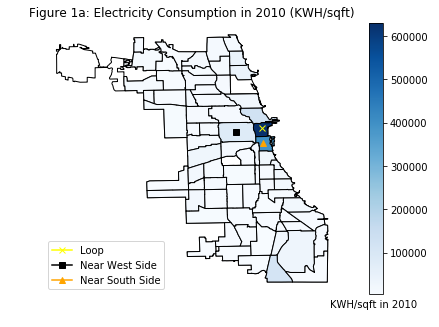

In [8]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_comms.plot(ax=gax, edgecolor='black', column='kwh_sqftmean', legend=True, cmap='Blues')

gax.set_title('Figure 1a: Electricity Consumption in 2010 (KWH/sqft)')

gax.annotate('KWH/sqft in 2010', xy=(0.75, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Yellow', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Black', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Orange', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

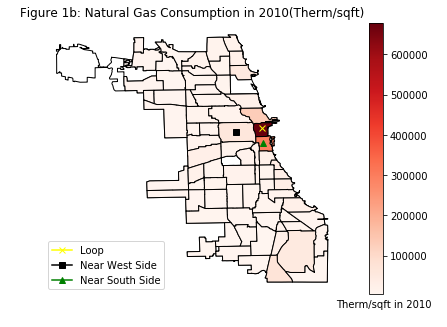

In [9]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_comms.plot(ax=gax, edgecolor='black', column='therm_sqftmean', legend=True, cmap='Reds')

gax.set_title('Figure 1b: Natural Gas Consumption in 2010(Therm/sqft)')

gax.annotate('Therm/sqft in 2010', xy=(0.75, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Yellow', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Black', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

### Below, I plot the energy consumption in communities across the city of Chicago.

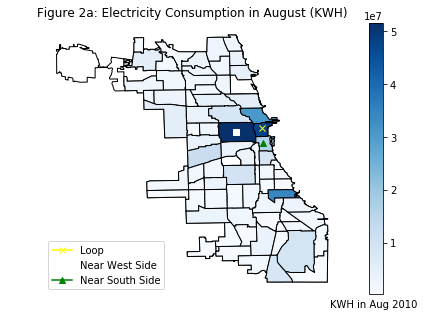

In [10]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_aug2.plot(ax=gax, edgecolor='black', column='kwh_aug', legend=True, cmap='Blues')

gax.set_title('Figure 2a: Electricity Consumption in August (KWH)')

gax.annotate('KWH in Aug 2010', xy=(0.75, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Yellow', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='White', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

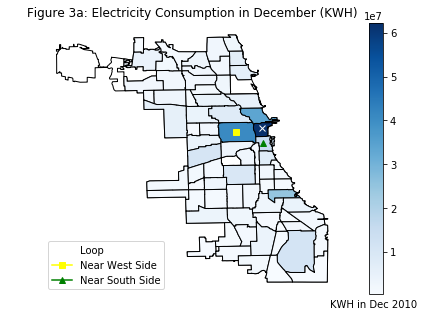

In [11]:
fig, gax = plt.subplots(figsize=(10, 5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_dec2.plot(ax=gax, edgecolor='black', column='kwh_dec', legend=True, cmap='Blues')

gax.set_title('Figure 3a: Electricity Consumption in December (KWH)')

gax.annotate('KWH in Dec 2010', xy=(0.75, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='White', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Yellow', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

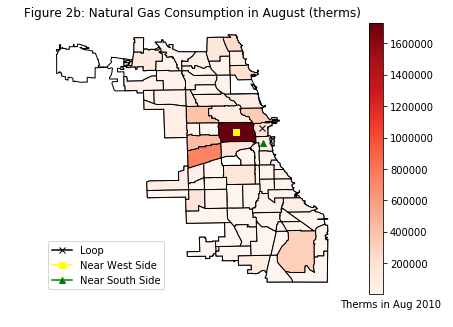

In [12]:
fig, gax = plt.subplots(figsize=(10,5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_aug2.plot(ax=gax, edgecolor='black', column='therm_aug', legend=True, cmap='Reds')

gax.set_title('Figure 2b: Natural Gas Consumption in August (therms)')

gax.annotate('Therms in Aug 2010', xy=(0.75, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Black', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Yellow', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

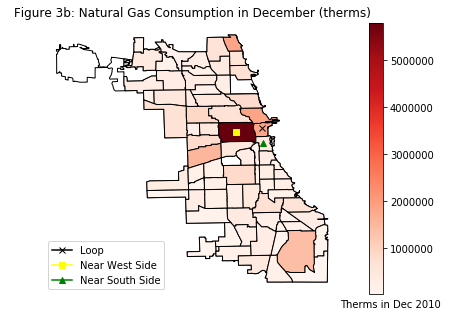

In [13]:
fig, gax = plt.subplots(figsize=(10, 5))

chicago_map.plot(ax=gax, edgecolor='black', color='white')
energy_dec2.plot(ax=gax, edgecolor='black', column='therm_dec', legend=True, cmap='Reds')

gax.set_title('Figure 3b: Natural Gas Consumption in December (therms)')

gax.annotate('Therms in Dec 2010', xy=(0.75, 0.06), xycoords='figure fraction')

gax.plot(-87.625, 41.88, marker='x', color='Black', label='Loop')

gax.plot(-87.665, 41.875, marker='s', color='Yellow', label='Near West Side')

gax.plot(-87.623, 41.858, marker='^', color='Green', label='Near South Side')

gax.legend(loc='lower left')

plt.axis('off')

plt.show()

## Next, I show how KWH/therm consumption per squarefoot varies between the three building types. I omit Industrial for most of my analysis because the data lacks sufficient observations to make meaningful claims regarding price and temperature coefficients. I also decided to split up commercial and residential demand into separate analyses because their demands are fundamentally different, shown below by the bar graph. Commercial energy requirements are far larger than those for residential energy which would suggest that they have a different demand.

In [14]:
# Here, I create residential, commercial, and industrial shares of building types. 

energy_noagg = energy2[(energy2['census block']!='n') & ~(energy2['total_kwh'].isnull())]

energy_noagg_gpd = energy_noagg.groupby(['build_type']).mean()

energy_noagg_gpd['kwh_sqftmean']

build_type
Commercial     21705.936650
Industrial     21538.000000
Residential     2987.307567
Name: kwh_sqftmean, dtype: float64

In [15]:
energy_noagg_gpd.reset_index(inplace=True)

energy_noagg_gpd1 = energy_noagg_gpd[['build_type', 'kwh_sqftmean']]
energy_noagg_gpd2 = energy_noagg_gpd[['build_type', 'therm_sqftmean']]

kwh_melt = energy_noagg_gpd1.melt(id_vars=['build_type'])
therm_melt = energy_noagg_gpd2.melt(id_vars=['build_type'])

print(kwh_melt)
therm_melt.head()

    build_type      variable         value
0   Commercial  kwh_sqftmean  21705.936650
1   Industrial  kwh_sqftmean  21538.000000
2  Residential  kwh_sqftmean   2987.307567


,build_type,variable,value
0,Commercial,therm_sqftmean,19434.809343
1,Industrial,therm_sqftmean,14401.934783
2,Residential,therm_sqftmean,2899.514607


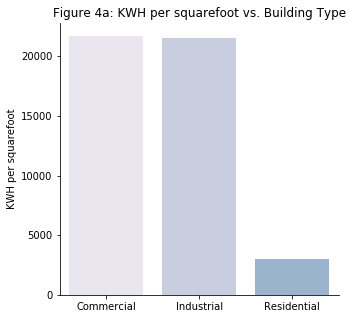

In [16]:
fig, my_ax =plt.subplots(figsize=(5, 5))

sns.barplot(x='build_type', y='value', data=kwh_melt,
           ax=my_ax, palette = sns.color_palette('PuBu'))

my_ax.set_xlabel('')
my_ax.set_ylabel('KWH per squarefoot')

my_ax.set_title('Figure 4a: KWH per squarefoot vs. Building Type')

plt.xticks(rotation='horizontal')
sns.despine(ax=my_ax)

plt.show()

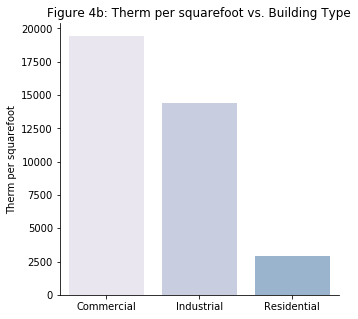

In [17]:
fig, my_ax =plt.subplots(figsize=(5, 5))

sns.barplot(x='build_type', y='value', data=therm_melt,
           ax=my_ax, palette = sns.color_palette('PuBu'))

my_ax.set_xlabel('')
my_ax.set_ylabel('Therm per squarefoot')

my_ax.set_title('Figure 4b: Therm per squarefoot vs. Building Type')

plt.xticks(rotation='horizontal')
sns.despine(ax=my_ax)

plt.show()

# Here, I look at the effect of price on electricity and natural gas (respectively) consumption for each of the building types using natural gas and electricity (respectively) as instruments.

I start with residential buildings.

In [18]:
temps = pd.read_excel('avg_chicago_temps.xlsx', header=1)

prices_kwh = pd.read_excel('kwh_prices_2010.xlsx', header=9)
prices_kwh.columns = map(str.lower, prices_kwh.columns)
prices_kwh2010 = prices_kwh[prices_kwh['year']==2010]
prices_kwh2010 = prices_kwh2010.melt(id_vars={'year'})
prices_kwh2010.rename(columns={'variable':'month', 'value':'price_kwh'}, inplace=True)
prices_kwh2010.drop('year', axis=1, inplace=True)

prices_therm = pd.read_excel('therm_prices_2010.xlsx', header=1)
prices_therm.rename(columns={'price/therm':'price_therm'}, inplace=True)

prices = pd.merge(left=prices_kwh2010, right=prices_therm, on='month', how='inner')

# I decided to put the price in terms of cents rather than dollars because the changes
# in each value from month to month are small enough that expressing the values in dollars
# is not particularly helpful.

prices['price_kwh'] = prices['price_kwh']*100
prices['price_therm'] = prices['price_therm']*100

prices.head()

,month,price_kwh,price_therm
0,jan,13.6,61.83
1,feb,13.9,62.35
2,mar,13.9,66.03
3,apr,13.7,51.65
4,may,13.8,44.35


In [19]:
# Here I create variables with only one of the building types.

energy_ind = energy2[(energy2['build_type']=='Industrial') & (energy2['census block']!='n')]
energy_com = energy2[(energy2['build_type']=='Commercial') & (energy2['census block']!='n')]
energy_res = energy2[(energy2['build_type']=='Residential') & (energy2['census block']!='n')]

In [20]:
# For the next three cells, I clean, prep, and merge the residential KWH and therm data for analysis.
# I split KWH and therm data before merging them once again because their sqft data is different.

res_kwh = energy_res[['census block', 'community', 'kwh_jan', 'kwh_feb', 'kwh_mar',
                          'kwh_apr', 'kwh_may', 'kwh_jun', 'kwh_jul', 'kwh_aug', 'kwh_sep',
                          'kwh_oct', 'kwh_nov', 'kwh_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'kwh_sqft']]

res_kwh = res_kwh.dropna()

res_kwhmlt = res_kwh.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house', 'kwh_sqft'})

res_kwhmlt.rename(columns={'variable':'month', 'value':'res_kwh'}, inplace=True)
res_kwhmlt = res_kwhmlt.replace({'kwh_jan':'jan', 'kwh_feb':'feb', 'kwh_mar':'mar', 'kwh_apr':'apr', 
              'kwh_may':'may', 'kwh_jun':'jun', 'kwh_jul':'jul', 'kwh_aug':'aug', 
              'kwh_sep':'sep', 'kwh_oct':'oct', 'kwh_nov':'nov', 'kwh_dec':'dec'})

res_kwh2 = pd.merge(left=res_kwhmlt, right=temps, on='month', how='left')
res_kwh2 = pd.merge(left=res_kwh2, right=prices, on='month', how='left')

res_kwh2['res_kwh_sqft'] = res_kwh2['res_kwh'] / res_kwh2['kwh_sqft']

res_kwh2 = res_kwh2[res_kwh2['res_kwh']>0]

res_kwh2.head()

,community,occ_units_pct,census block,avg_stories,kwh_sqft,occ_units,pop,avg_build_age,occ_house,month,res_kwh,avg_temp,price_kwh,price_therm,res_kwh_sqft
0,Ashburn,0.9254,170317005014004,2.0,10892.0,62.0,112.0,41.0,62.0,jan,7334.0,22,13.6,61.83,0.673338
1,Austin,0.8710,170312521011000,3.0,4500.0,27.0,79.0,99.0,27.0,jan,2461.0,22,13.6,61.83,0.546889
3,Chatham,0.8955,170314401011011,3.0,9012.0,60.0,144.0,47.0,60.0,jan,7542.0,22,13.6,61.83,0.836884
5,Chicago Lawn,0.6552,170316609002002,2.0,8121.0,19.0,61.0,43.0,19.0,jan,828.0,22,13.6,61.83,0.101958
6,Clearing,0.9079,170316406002023,3.0,5182.0,69.0,114.0,39.0,69.0,jan,4632.0,22,13.6,61.83,0.893863


In [21]:
res_therm = energy_res[['census block', 'community', 'therm_jan', 'therm_feb', 'therm_mar',
                          'therm_apr', 'therm_may', 'therm_jun', 'therm_jul', 'therm_aug', 'therm_sep',
                          'therm_oct', 'therm_nov', 'therm_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'therm_sqft']]

res_therm = res_therm.dropna()

res_thermmlt = res_therm.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house', 'therm_sqft'})

res_thermmlt.rename(columns={'variable':'month', 'value':'res_therm'}, inplace=True)
res_thermmlt = res_thermmlt.replace({'therm_jan':'jan', 'therm_feb':'feb', 'therm_mar':'mar', 'therm_apr':'apr', 
              'therm_may':'may', 'therm_jun':'jun', 'therm_jul':'jul', 'therm_aug':'aug', 
              'therm_sep':'sep', 'therm_oct':'oct', 'therm_nov':'nov', 'therm_dec':'dec'})

res_therm2 = pd.merge(left=res_thermmlt, right=temps, on='month', how='left')
res_therm2 = pd.merge(left=res_therm2, right=prices, on='month', how='left')

res_therm2['res_therm_sqft'] = res_therm2['res_therm'] / res_therm2['therm_sqft']

res_therm2 = res_therm2[res_therm2['res_therm']>0]

res_therm2.head()

,community,occ_units_pct,census block,avg_stories,occ_units,pop,avg_build_age,therm_sqft,occ_house,month,res_therm,avg_temp,price_kwh,price_therm,res_therm_sqft
0,Archer Heights,0.9582,170315704001006,2.0,23.0,89.0,71.33,11134.0,23.0,jan,2326.0,22,13.6,61.83,0.208910
1,Avondale,0.9375,170312109001038,2.0,15.0,33.0,101.00,1936.0,15.0,jan,285.0,22,13.6,61.83,0.147211
2,Beverly,1.0000,170317205002014,1.0,1.0,2.0,51.00,6800.0,1.0,jan,243.0,22,13.6,61.83,0.035735
3,Clearing,0.9200,170316404001011,1.0,23.0,60.0,0.00,3920.0,23.0,jan,555.0,22,13.6,61.83,0.141582
4,Dunning,1.0000,170311703003003,1.0,16.0,51.0,79.00,1723.0,16.0,jan,326.0,22,13.6,61.83,0.189205


In [22]:
res_both = pd.merge(left=res_kwh2, right=res_therm2, on=['census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'month', 'avg_temp', 'price_kwh', 'price_therm'], how='inner')

res_both.head()

,community,occ_units_pct,census block,avg_stories,kwh_sqft,occ_units,pop,avg_build_age,occ_house,month,res_kwh,avg_temp,price_kwh,price_therm,res_kwh_sqft,therm_sqft,res_therm,res_therm_sqft
0,Lincoln Park,1.0000,170310705003003,4.0,7524.0,22.0,61.0,12.0,22.0,jan,242.0,22,13.6,61.83,0.032164,7524.0,1093.0,0.145268
1,Near North Side,1.0000,170310804001003,3.0,5804.0,18.0,36.0,116.0,18.0,jan,1959.0,22,13.6,61.83,0.337526,5804.0,1016.0,0.175052
2,South Shore,0.8679,170314314003001,2.5,6420.0,138.0,224.0,114.5,138.0,jan,1266.0,22,13.6,61.83,0.197196,6420.0,1353.0,0.210748
3,Albany Park,0.9375,170311401001001,3.0,48825.0,60.0,132.0,65.5,60.0,jan,11921.0,22,13.6,61.83,0.244158,48825.0,7247.0,0.148428
4,Albany Park,0.9375,170311401001001,2.0,3306.0,60.0,132.0,86.0,60.0,jan,1233.0,22,13.6,61.83,0.372958,3306.0,321.0,0.097096


In [23]:
# The instrument res_therm_sqft is relevant!
res_kwh_first = smf.ols('price_kwh ~ res_therm_sqft +avg_build_age + avg_stories + pop', res_both).fit(cov_type='HC1')

print(res_kwh_first.summary())

                            OLS Regression Results                            
Dep. Variable:              price_kwh   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     46.52
Date:                Thu, 27 Dec 2018   Prob (F-statistic):           3.72e-39
Time:                        15:54:03   Log-Likelihood:            -6.1569e+05
No. Observations:              541802   AIC:                         1.231e+06
Df Residuals:                  541797   BIC:                         1.231e+06
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.9528      0.026    566.

In [24]:
res_kwh = iv.IV2SLS.from_formula('res_kwh_sqft ~ 1 + [price_kwh ~ res_therm_sqft] + avg_build_age + avg_stories + pop', res_both).fit()

print(res_kwh)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           res_kwh_sqft   R-squared:                     -0.1223
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1223
No. Observations:              541802   F-statistic:                    2510.2
Date:                Thu, Dec 27 2018   P-value (F-stat)                0.0000
Time:                        15:54:10   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         2.6941     0.2546     10.581     0.0000      2.1951      3.1931
avg_build_age    -0.0011   7.53e-05    -

In [25]:
# The instrument res_kwh_sqft is relevant!
res_therm_first = smf.ols('price_therm ~ res_kwh_sqft + avg_build_age + avg_stories + pop', res_both).fit(cov_type='HC1')

print(res_therm_first.summary())

                            OLS Regression Results                            
Dep. Variable:            price_therm   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     36.08
Date:                Thu, 27 Dec 2018   Prob (F-statistic):           3.38e-30
Time:                        15:54:21   Log-Likelihood:            -1.8747e+06
No. Observations:              541802   AIC:                         3.749e+06
Df Residuals:                  541797   BIC:                         3.749e+06
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        53.8455      0.105    513.443

In [26]:
res_therm = iv.IV2SLS.from_formula('res_therm_sqft ~ 1 + [price_therm ~ res_kwh_sqft] + avg_build_age + avg_stories + pop', res_both).fit()

print(res_therm)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         res_therm_sqft   R-squared:                     -1.9354
Estimator:                    IV-2SLS   Adj. R-squared:                -1.9354
No. Observations:              541802   F-statistic:                    381.65
Date:                Thu, Dec 27 2018   P-value (F-stat)                0.0000
Time:                        15:54:27   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         0.8746     0.1014     8.6240     0.0000      0.6758      1.0734
avg_build_age  5.573e-05  1.109e-05     

### Now, I look at the effect of price on kwh/therm (respectively) consumption of commercial buildings using residential therm/kwh (respectively) consumption as an instrument.

In [27]:
# For the next three cells, I clean and prep the commercial KWH and therm energy data for analysis.
# I split KWH and therm data before merging them once again because their sqft data is different.

com_kwh = energy_com[['census block', 'community', 'kwh_jan', 'kwh_feb', 'kwh_mar',
                          'kwh_apr', 'kwh_may', 'kwh_jun', 'kwh_jul', 'kwh_aug', 'kwh_sep',
                          'kwh_oct', 'kwh_nov', 'kwh_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'kwh_sqft']]

com_kwh = com_kwh.dropna()

com_kwhmlt = com_kwh.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house', 'kwh_sqft'})

com_kwhmlt.rename(columns={'variable':'month', 'value':'com_kwh'}, inplace=True)
com_kwhmlt = com_kwhmlt.replace({'kwh_jan':'jan', 'kwh_feb':'feb', 'kwh_mar':'mar', 'kwh_apr':'apr', 
              'kwh_may':'may', 'kwh_jun':'jun', 'kwh_jul':'jul', 'kwh_aug':'aug', 
              'kwh_sep':'sep', 'kwh_oct':'oct', 'kwh_nov':'nov', 'kwh_dec':'dec'})

com_kwh2 = pd.merge(left=com_kwhmlt, right=temps, on='month', how='left')
com_kwh2 = pd.merge(left=com_kwh2, right=prices, on='month', how='left')

com_kwh2['com_kwh_sqft'] = com_kwh2['com_kwh'] / com_kwh2['kwh_sqft']

com_kwh2 = com_kwh2[com_kwh2['com_kwh']>0]

com_kwh2.head()

,community,occ_units_pct,census block,avg_stories,kwh_sqft,occ_units,pop,avg_build_age,occ_house,month,com_kwh,avg_temp,price_kwh,price_therm,com_kwh_sqft
1,Austin,0.9365,170312520004000,2.0,1988.0,59.0,64.0,131.0,59.0,jan,1470.0,22,13.6,61.83,0.739437
2,Avondale,0.8462,170312105012012,1.0,4190.0,33.0,53.0,0.0,33.0,jan,6113.0,22,13.6,61.83,1.458950
4,Avondale,0.7692,170312106023008,2.0,3556.0,60.0,207.0,96.5,60.0,jan,1593.0,22,13.6,61.83,0.447975
5,Avondale,0.9375,170312107001003,2.0,3000.0,15.0,58.0,121.0,15.0,jan,945.0,22,13.6,61.83,0.315000
6,Avondale,1.0000,170312109001008,1.0,18700.0,1.0,2.0,63.0,1.0,jan,4006.0,22,13.6,61.83,0.214225


In [28]:
com_therm = energy_com[['census block', 'community', 'therm_jan', 'therm_feb', 'therm_mar',
                          'therm_apr', 'therm_may', 'therm_jun', 'therm_jul', 'therm_aug', 'therm_sep',
                          'therm_oct', 'therm_nov', 'therm_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'therm_sqft']]

com_therm = com_therm.dropna()

com_thermmlt = com_therm.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house', 'therm_sqft'})

com_thermmlt.rename(columns={'variable':'month', 'value':'com_therm'}, inplace=True)
com_thermmlt = com_thermmlt.replace({'therm_jan':'jan', 'therm_feb':'feb', 'therm_mar':'mar', 'therm_apr':'apr', 
              'therm_may':'may', 'therm_jun':'jun', 'therm_jul':'jul', 'therm_aug':'aug', 
              'therm_sep':'sep', 'therm_oct':'oct', 'therm_nov':'nov', 'therm_dec':'dec'})

com_therm2 = pd.merge(left=com_thermmlt, right=temps, on='month', how='left')
com_therm2 = pd.merge(left=com_therm2, right=prices, on='month', how='left')

com_therm2['com_therm_sqft'] = com_therm2['com_therm'] / com_therm2['therm_sqft']

com_therm2 = com_therm2[com_therm2['com_therm']>0]

com_therm2.head()

,community,occ_units_pct,census block,avg_stories,occ_units,pop,avg_build_age,therm_sqft,occ_house,month,com_therm,avg_temp,price_kwh,price_therm,com_therm_sqft
0,Avondale,0.7049,170312105023000,1.0,43.0,176.0,0.0,3967.0,43.0,jan,535.0,22,13.6,61.83,0.134863
1,Belmont Cragin,0.8500,170311903003009,1.0,34.0,109.0,0.0,2128.0,34.0,jan,888.0,22,13.6,61.83,0.417293
2,Brighton Park,0.0000,170315801002010,1.0,0.0,0.0,0.0,14878.0,0.0,jan,9935.0,22,13.6,61.83,0.667764
3,Chicago Lawn,0.8125,170316606005009,2.0,26.0,120.0,85.0,4902.0,26.0,jan,1005.0,22,13.6,61.83,0.205018
4,Chicago Lawn,0.8000,170316607002002,1.0,20.0,90.0,92.5,1918.0,20.0,jan,692.0,22,13.6,61.83,0.360792


In [29]:
com_both = pd.merge(left=com_kwh2, right=com_therm2, on=['census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'month', 'avg_temp', 'price_kwh', 'price_therm'], how='inner')

com_both.head()

,community,occ_units_pct,census block,avg_stories,kwh_sqft,occ_units,pop,avg_build_age,occ_house,month,com_kwh,avg_temp,price_kwh,price_therm,com_kwh_sqft,therm_sqft,com_therm,com_therm_sqft
0,Avondale,0.8462,170312105012012,1.0,4190.0,33.0,53.0,0.0,33.0,jan,6113.0,22,13.6,61.83,1.458950,3482.0,2639.0,0.757898
1,Avondale,0.8462,170312105012012,1.0,3482.0,33.0,53.0,0.0,33.0,jan,15240.0,22,13.6,61.83,4.376795,3482.0,2639.0,0.757898
2,South Chicago,0.8095,170318339002020,1.0,4364.0,34.0,100.0,0.0,34.0,jan,3295.0,22,13.6,61.83,0.755041,4364.0,1809.0,0.414528
3,South Shore,0.7448,170314313012009,1.0,5295.0,73.0,187.0,0.0,73.0,jan,383.0,22,13.6,61.83,0.072332,5295.0,1309.0,0.247214
4,Albany Park,0.8824,170311407023009,2.0,5236.0,45.0,80.0,85.0,45.0,jan,626.0,22,13.6,61.83,0.119557,5236.0,7.0,0.001337


In [30]:
# The instrument com_therm_sqft is relevant!
com_kwh_first = smf.ols('price_kwh ~ com_therm_sqft + avg_build_age + occ_units_pct + avg_stories + pop', com_both).fit(cov_type='HC1')

print(com_kwh_first.summary())

                            OLS Regression Results                            
Dep. Variable:              price_kwh   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     37.82
Date:                Thu, 27 Dec 2018   Prob (F-statistic):           6.49e-39
Time:                        15:54:49   Log-Likelihood:            -1.8629e+05
No. Observations:              151240   AIC:                         3.726e+05
Df Residuals:                  151234   BIC:                         3.726e+05
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.7139      0.015    950.

In [31]:
com_kwh = iv.IV2SLS.from_formula('com_kwh_sqft ~ 1 + [price_kwh ~ com_therm_sqft] + avg_build_age + avg_stories + pop', com_both).fit()

print(com_kwh)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           com_kwh_sqft   R-squared:                     -0.4207
Estimator:                    IV-2SLS   Adj. R-squared:                -0.4207
No. Observations:              151240   F-statistic:                    527.52
Date:                Thu, Dec 27 2018   P-value (F-stat)                0.0000
Time:                        15:54:56   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         23.775     1.7171     13.846     0.0000      20.410      27.141
avg_build_age    -0.0028     0.0002    -

In [32]:
# The instrument com_kwh_sqft is relevant!
com_therm_first = smf.ols('price_therm ~ com_kwh_sqft + avg_stories + avg_build_age + pop', com_both).fit(cov_type='HC1')

print(com_therm_first.summary())

                            OLS Regression Results                            
Dep. Variable:            price_therm   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     19.45
Date:                Thu, 27 Dec 2018   Prob (F-statistic):           5.11e-16
Time:                        15:55:06   Log-Likelihood:            -5.2380e+05
No. Observations:              151240   AIC:                         1.048e+06
Df Residuals:                  151235   BIC:                         1.048e+06
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        52.8595      0.040   1320.305

In [33]:
# The fact that the p-value on price_therm is so high suggests that there is an ommitted variable

com_therm = iv.IV2SLS.from_formula('com_therm_sqft ~ 1 + [price_therm ~ com_kwh_sqft] + avg_stories + avg_build_age + pop', com_both).fit()

print(com_therm)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         com_therm_sqft   R-squared:                     -23.064
Estimator:                    IV-2SLS   Adj. R-squared:                -23.064
No. Observations:              151240   F-statistic:                    83.229
Date:                Thu, Dec 27 2018   P-value (F-stat)                0.0000
Time:                        15:55:12   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         8.0262     0.9618     8.3447     0.0000      6.1410      9.9113
avg_stories      -0.0020     0.0012    -

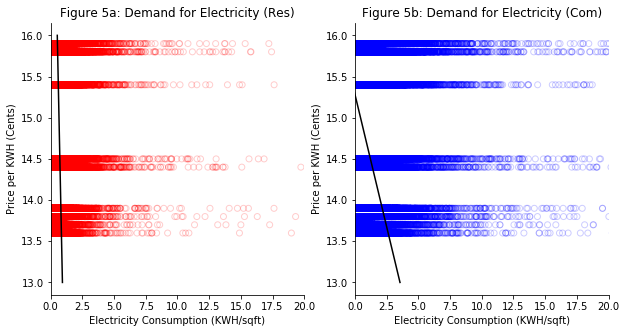

In [34]:
# I plot the the coefficient of the model with the actual values just to have an idea of how well the model 
# fits the realized values. Some values are predicted to be negative because, suggesting that there may be an omitted
# variable that I am unable to account for (natural gas: likely the price shock; commercial electricity: unsure at the moment,
# warrants further research)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

x = range(13, 17)
x2 = range(13, 17)

p = res_kwh.params
p2 = com_kwh.params

y = [p.Intercept + p.price_kwh*i for i in x]
y2 = [p2.Intercept + p2.price_kwh*i for i in x2]

ax[0].plot(y, x, color='black')
ax[1].plot(y2, x2, color='black')

ax[0].scatter(res_both['res_kwh_sqft'], res_both['price_kwh'], facecolor='None', edgecolor='red', alpha=0.20)
ax[1].scatter(com_both['com_kwh_sqft'], com_both['price_kwh'], facecolor='None', edgecolor='blue', alpha=0.20)

ax[0].set_title('Figure 5a: Demand for Electricity (Res)')
ax[1].set_title('Figure 5b: Demand for Electricity (Com)')

ax[0].set_xlabel('Electricity Consumption (KWH/sqft)')
ax[1].set_xlabel('Electricity Consumption (KWH/sqft)')

ax[0].set_ylabel('Price per KWH (Cents)')
ax[1].set_ylabel('Price per KWH (Cents)')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_xlim(0, 20)
ax[1].set_xlim(0, 20)


plt.show()

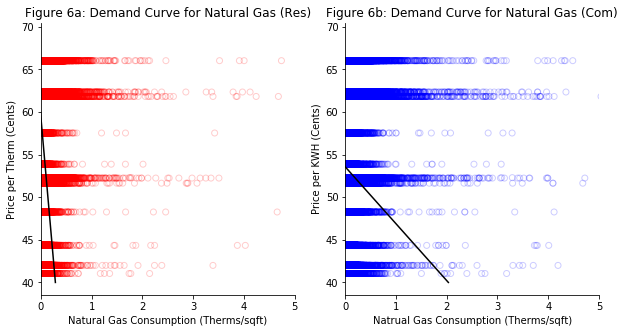

In [35]:
# Refer to previous cell for explanation of plots.

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x = range(40, 70)
x2 = range(40, 70)

p = res_therm.params
p2 = com_therm.params

y = [p.Intercept + p.price_therm*i for i in x]
y2 = [p2.Intercept + p2.price_therm*i for i in x2]

ax[0].plot(y, x, color='black')
ax[1].plot(y2, x2, color='black')

ax[0].scatter(res_both['res_therm_sqft'], res_both['price_therm'], facecolor='None', edgecolor='red', alpha=0.20)
ax[1].scatter(com_both['com_therm_sqft'], com_both['price_therm'], facecolor='None', edgecolor='blue', alpha=0.20)

ax[0].set_title('Figure 6a: Demand Curve for Natural Gas (Res)')
ax[1].set_title('Figure 6b: Demand Curve for Natural Gas (Com)')

ax[0].set_xlabel('Natural Gas Consumption (Therms/sqft)')
ax[1].set_xlabel('Natrual Gas Consumption (Therms/sqft)')

ax[0].set_ylabel('Price per Therm (Cents)')
ax[1].set_ylabel('Price per KWH (Cents)')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_xlim(0,5)
ax[1].set_xlim(0,5)

plt.show()

### Now I will look at the kwh consumption of industrial buildings; I don't include this in my project report because industrial has too few observations to make meaningful conclusions.

In [ ]:
ind_kwh = energy_ind[['census block', 'community', 'kwh_jan', 'kwh_feb', 'kwh_mar',
                          'kwh_apr', 'kwh_may', 'kwh_jun', 'kwh_jul', 'kwh_aug', 'kwh_sep',
                          'kwh_oct', 'kwh_nov', 'kwh_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house']]

ind_kwh = ind_kwh.dropna()

ind_kwhmlt = ind_kwh.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house'})

ind_kwhmlt.rename(columns={'variable':'month', 'value':'ind_kwh'}, inplace=True)
ind_kwhmlt = ind_kwhmlt.replace({'kwh_jan':'jan', 'kwh_feb':'feb', 'kwh_mar':'mar', 'kwh_apr':'apr', 
              'kwh_may':'may', 'kwh_jun':'jun', 'kwh_jul':'jul', 'kwh_aug':'aug', 
              'kwh_sep':'sep', 'kwh_oct':'oct', 'kwh_nov':'nov', 'kwh_dec':'dec'})

ind_kwh2 = pd.merge(left=ind_kwhmlt, right=temps, on='month', how='left')
ind_kwh2 = pd.merge(left=ind_kwh2, right=prices, on='month', how='left')

ind_kwh2 = ind_kwh2[ind_kwh2['ind_kwh']>0]

ind_kwh2.head()

In [ ]:
ind_therm = energy_ind[['census block', 'community', 'therm_jan', 'therm_feb', 'therm_mar',
                          'therm_apr', 'therm_may', 'therm_jun', 'therm_jul', 'therm_aug', 'therm_sep',
                          'therm_oct', 'therm_nov', 'therm_dec', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house']]

ind_therm = ind_therm.dropna()

ind_thermmlt = ind_therm.melt(id_vars={'census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                      'occ_units', 'occ_units_pct', 'occ_house'})

ind_thermmlt.rename(columns={'variable':'month', 'value':'ind_therm'}, inplace=True)
ind_thermmlt = ind_thermmlt.replace({'therm_jan':'jan', 'therm_feb':'feb', 'therm_mar':'mar', 'therm_apr':'apr', 
              'therm_may':'may', 'therm_jun':'jun', 'therm_jul':'jul', 'therm_aug':'aug', 
              'therm_sep':'sep', 'therm_oct':'oct', 'therm_nov':'nov', 'therm_dec':'dec'})

ind_therm2 = pd.merge(left=ind_thermmlt, right=temps, on='month', how='left')
ind_therm2 = pd.merge(left=ind_therm2, right=prices, on='month', how='left')

ind_therm2.tail()

In [ ]:
ind_both = pd.merge(left=ind_kwh2, right=ind_therm2, on=['census block', 'community', 'avg_stories', 'avg_build_age', 'pop',
                          'occ_units', 'occ_units_pct', 'occ_house', 'month', 'avg_temp', 'price_kwh', 'price_therm'], how='inner')

ind_both.head()

# NOW I look at how average temperature affects aggregate kwh/therm consumption over the course of the year.

I start with the residential buildings.

In [ ]:
res_temp_kwh = smf.ols('res_kwh ~ avg_temp + avg_stories + avg_build_age + pop', res_both).fit(covtype='HC1')

print(res_temp_kwh.summary())

In [ ]:
res_temp_therm = smf.ols('res_therm ~ avg_stories + avg_temp + avg_build_age + pop', res_both).fit(cov_type='HC1')

print(res_temp_therm.summary())

### Next I look at how average temperature affects aggregate kwh/therm consumption in commercial buildings.

In [ ]:
com_temp_kwh = smf.ols('com_kwh ~ avg_stories + avg_build_age + avg_temp + pop', com_both).fit(cov_type='HC1')

print(com_temp_kwh.summary())

In [ ]:
com_temp_therm = smf.ols('com_therm ~ avg_stories + avg_build_age + avg_temp + pop', com_both).fit(cov_type='HC1')

print(com_temp_therm.summary())

### Below, I include a partial analysis of industrial data; I do not include it in my report because I don't think the findings are as robust as those for commercial and residential buildings.

In [ ]:
ind_both.head()

In [ ]:
ind_temp_kwh = smf.ols('ind_kwh ~ avg_stories + avg_build_age + avg_temp + pop', ind_both).fit(cov_type='HC1')

print(ind_temp_kwh.summary())

In [ ]:
ind_temp_therm = smf.ols('ind_therm ~ avg_stories + avg_build_age + avg_temp + pop', ind_both).fit(cov_type='HC1')

print(ind_temp_therm.summary())

### This is the seasonality of the data set.

In [ ]:
seasonality_res = res_both.groupby('month').mean()

seasonality_res = seasonality_res.loc[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]

seasonality_res = seasonality_res[['price_kwh', 'res_kwh', 'price_therm', 'res_therm', 'avg_temp']]

seasonality_res

In [ ]:
seasonality_com = com_both.groupby('month').mean()

seasonality_com = seasonality_com.loc[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']]

seasonality_com = seasonality_com[['price_kwh', 'com_kwh', 'price_therm', 'com_therm', 'avg_temp']]

seasonality_com